## Energy Consumption Forecasting

**Problem Statement:**
> Indian government wants to switch towards green energy. BY 2030 their target is to fulfill 90% of total energy demand using green energy. So they need to analyse future energy demand. 

> We have given a past 10 years energy demand data which include energy demand for each 2 hours for 10 years.

> We need to analyse data and on basis of intution from analysis we need to develope machine learning model which will forecst energy consumption in future.

**Methods:**

1. Import Libraries
2. Import Dataset
3. Exploratory Data Analysis: Data Cleaning, Missing Values, Outliers
4. Feature Selection and Transformation
5. Use and select appropriate ML Model
6. Evaluation of model: accuracy, rmse
7. Hyper Parameter Tuning

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV


In [2]:
# importing dataset
df = pd.read_csv("train_IxoE5JN.csv")
df

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500
...,...,...,...
94987,94988,2018-12-31 19:00:00,2528.446800
94988,94989,2018-12-31 20:00:00,2461.883600
94989,94990,2018-12-31 21:00:00,2365.994400
94990,94991,2018-12-31 22:00:00,2342.942800


### EDA:

**Data Cleaning:**

In [3]:
# dropping rowId column bcuz it is uneccesory
df.drop(["row_id"], axis = 1, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  94992 non-null  object 
 1   energy    93092 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.4+ MB


Let's set datetime column as index so that we can visualize energy consumption time frame wise.

And also change index dtype from `object` to `datetime`.

In [4]:
df = df.set_index("datetime")
df.index = pd.to_datetime(df.index)

df.head()

,energy
datetime,
2008-03-01 00:00:00,1259.985563
2008-03-01 01:00:00,1095.541500
2008-03-01 02:00:00,1056.247500
2008-03-01 03:00:00,1034.742000
2008-03-01 04:00:00,1026.334500


Checking for **missing values**:

In [5]:
df.isnull().sum()

energy    1900
dtype: int64

In [6]:
# calculating percentage of null values
df.isnull().sum()/len(df) * 100

energy    2.000168
dtype: float64

We have `1900 rows` contain null values.

But we can see that missing data is only `2%` of our total data.

So its better to drop it.

In [7]:
df.dropna(inplace = True)

df

,energy
datetime,
2008-03-01 00:00:00,1259.985563
2008-03-01 01:00:00,1095.541500
2008-03-01 02:00:00,1056.247500
2008-03-01 03:00:00,1034.742000
2008-03-01 04:00:00,1026.334500
...,...
2018-12-31 19:00:00,2528.446800
2018-12-31 20:00:00,2461.883600
2018-12-31 21:00:00,2365.994400


In [8]:
df.isnull().sum()

energy    0
dtype: int64

Now we have data contain zero null values.

**Pattern:**
Now we will plot energy demand w.r.t datetime. 

In [9]:
color_pal = sns.color_palette()
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

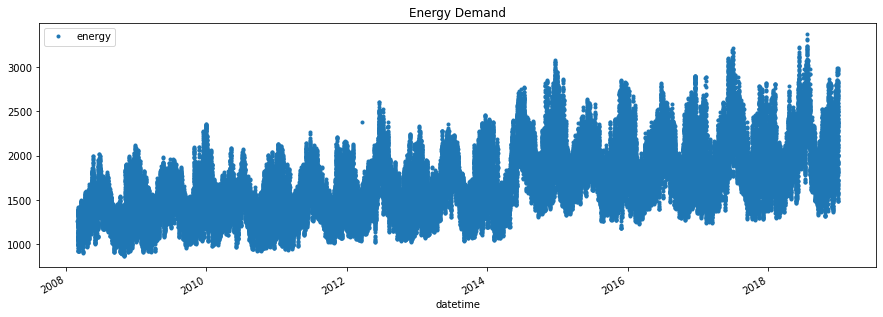

In [10]:
df.plot(style = '.', figsize = (15,5), color = color_pal[0], title = "Energy Demand")
plt.style.use('fivethirtyeight')
plt.show()

We can see that energy demand follows pattern : ` Seasonal Pattern plus Linear Growth.`

**Feature Creation**

In [11]:
# defining function for feature creation
def create_features(df):
    """
    Creates time series feature based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek    # mon : 0,.., sat : 5, sun : 6
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df


In [12]:
df = create_features(df)
df

,energy,hour,day_of_week,day_of_month,month,quarter,year
datetime,,,,,,,
2008-03-01 00:00:00,1259.985563,0,5,1,3,1,2008
2008-03-01 01:00:00,1095.541500,1,5,1,3,1,2008
2008-03-01 02:00:00,1056.247500,2,5,1,3,1,2008
2008-03-01 03:00:00,1034.742000,3,5,1,3,1,2008
2008-03-01 04:00:00,1026.334500,4,5,1,3,1,2008
...,...,...,...,...,...,...,...
2018-12-31 19:00:00,2528.446800,19,0,31,12,4,2018
2018-12-31 20:00:00,2461.883600,20,0,31,12,4,2018
2018-12-31 21:00:00,2365.994400,21,0,31,12,4,2018


We can create one more feature base on **holidays**.

We will mark 1 if that date is holiday otherwise 0.

In [13]:
df['year'].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
      dtype=int64)

First we require to get list of dates which are holidays in India for all years.

In [14]:
# importing holidays library to get holidays for india.
from datetime import date
import holidays

In [15]:
# in this way we can get holiday dates
holiday_2022 = holidays.India(years = 2015)
for date, occasion in holiday_2022.items():
    print(f'{date} : {occasion}')

2015-01-14 : Makar Sankranti / Pongal
2015-01-26 : Republic Day
2015-08-15 : Independence Day
2015-10-02 : Gandhi Jayanti
2015-05-01 : Labour Day
2015-12-25 : Christmas
2015-11-11 : Diwali
2015-03-06 : Holi


In [16]:
def holiday_mark(df):
    holiday_dt = []
    yrs = df['year'].unique()   

    holiday_i = holidays.India(years = yrs)      # gives output in form of dictionary

    for date, occasion in holiday_i.items(): 
        holiday_dt.append(date)                # only appending date for holidays

    date = pd.Series(df.index.date)            # creating data series which contain all dates
    holiday =[]
    for i in range(len(date)):
        holiday.append(int(date.iloc[i] in holiday_dt))   # if date is in holiday list mapping it to 1 else 0
    
    df["holiday"] = holiday
    
    df['holiday'] = np.where(df['day_of_week'] > 4, 1, 0)   # considering weekend as holiday
    
    return df

In [17]:
df = holiday_mark(df)
df.head()

,energy,hour,day_of_week,day_of_month,month,quarter,year,holiday
datetime,,,,,,,,
2008-03-01 00:00:00,1259.985563,0,5,1,3,1,2008,1
2008-03-01 01:00:00,1095.541500,1,5,1,3,1,2008,1
2008-03-01 02:00:00,1056.247500,2,5,1,3,1,2008,1
2008-03-01 03:00:00,1034.742000,3,5,1,3,1,2008,1
2008-03-01 04:00:00,1026.334500,4,5,1,3,1,2008,1


In [18]:
df['holiday'].value_counts()

0    66455
1    26637
Name: holiday, dtype: int64

**Data Visualization:**

Adding day name column for visualization purpose.

In [19]:
df["day"]=df.index.day_name()

Now we will see energy demand pattern at various time frame.

<AxesSubplot:xlabel='year', ylabel='energy'>

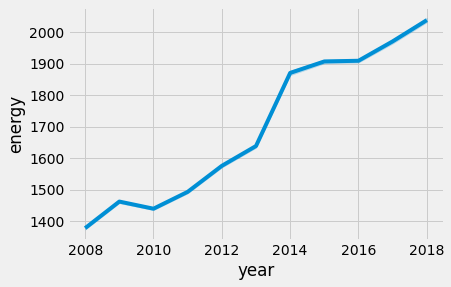

In [20]:
sns.lineplot(data=df,x="year",y="energy")

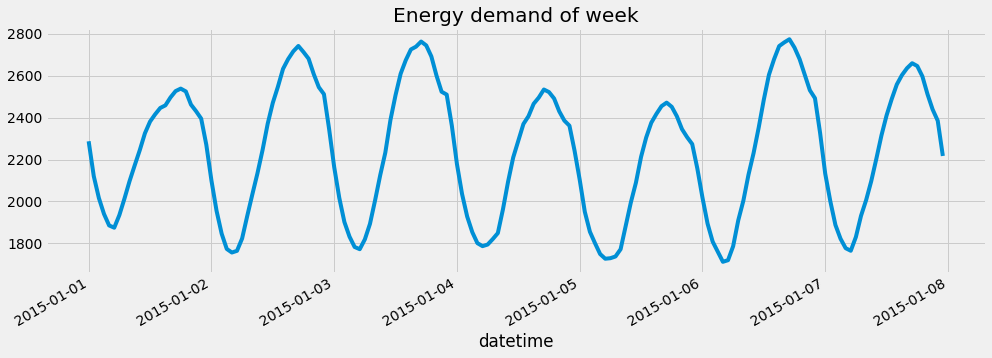

In [21]:
# plotting graph for one week
plt.style.use('fivethirtyeight')
df['energy'].loc[(df.index >= '01-01-2015') & (df.index < '01-08-2015')].plot(figsize=(15,5),title = 'Energy demand of week')
plt.show()

<AxesSubplot:title={'center':'Day wise energy consumption'}, xlabel='day'>

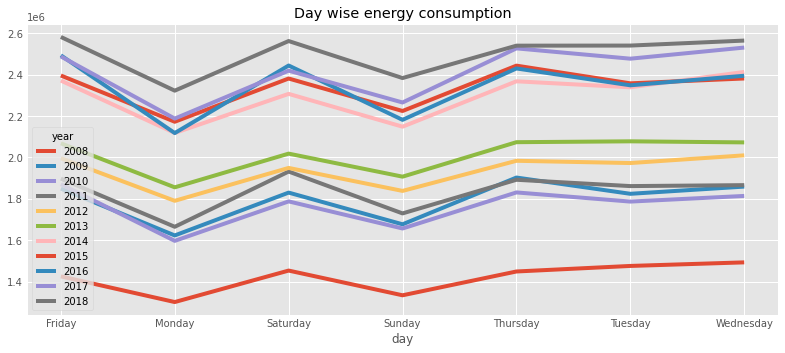

In [22]:
plt.style.use('ggplot')

df.groupby(['day','year'])['energy'].sum().unstack().plot(figsize=(12,5), title = 'Day wise energy consumption')

<AxesSubplot:title={'center':'Hour wise energy consumption'}, xlabel='hour'>

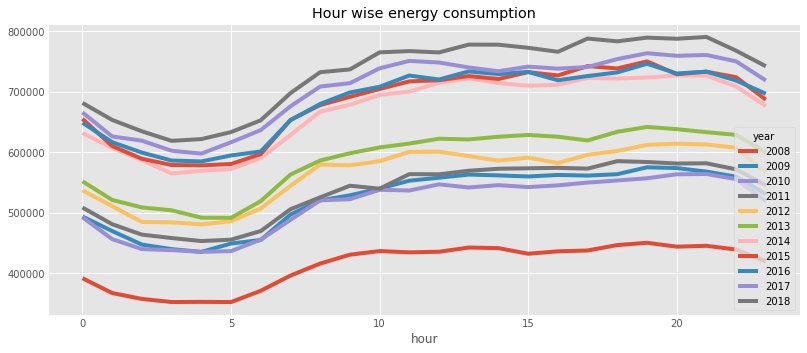

In [23]:
df.groupby(['hour','year'])['energy'].sum().unstack().plot(figsize=(12,5), title = 'Hour wise energy consumption')

From above we can see that:

`Energy demand during night is low`

`Energy demand on moday and on sunday is low`

**Outliers:**
We can plot box chart w.r.t energy consumption for month, year and hour.

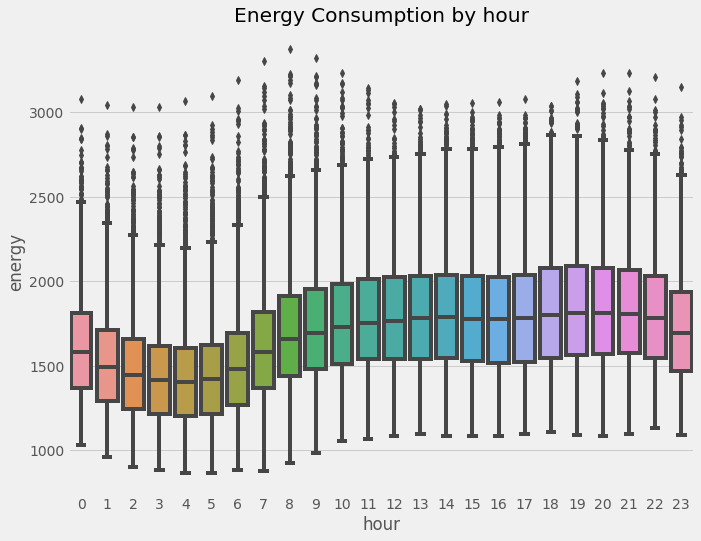

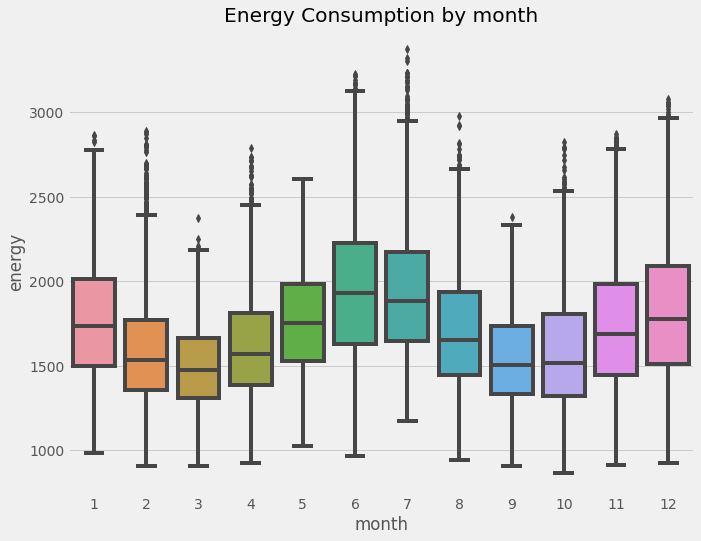

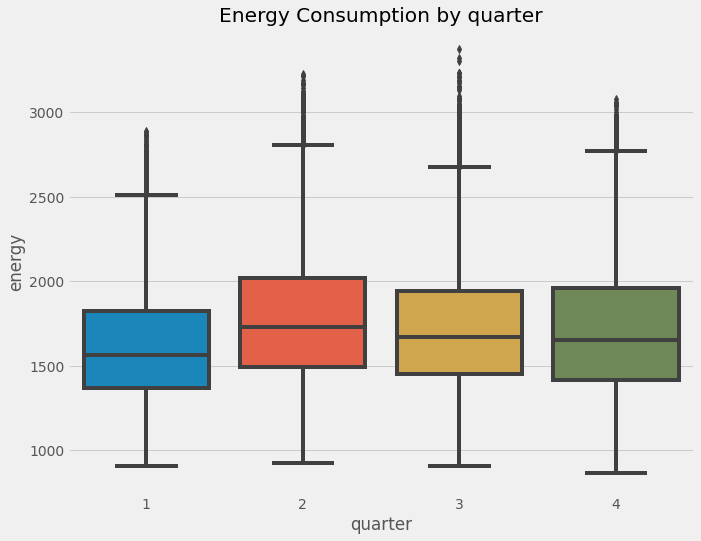

In [24]:
def box_plot(df, x, y):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize = (10,8))
    sns.boxplot(data = df, x = x, y = y)
    ax.set_title('Energy Consumption by ' + x)
    plt.style.use('fivethirtyeight')
    plt.show()
    return
box_plot(df, 'hour', 'energy')
box_plot(df, 'month', 'energy')
box_plot(df, 'quarter', 'energy')

We can see that outliers present for each time frame.

But we are not going to handle it for now.

In [25]:
# dropping day column as we have no use of it.
df.drop(['day'], axis = 1, inplace = True)

**Correlations:** Visualize independnt Feature and Target Relationship.

<AxesSubplot:>

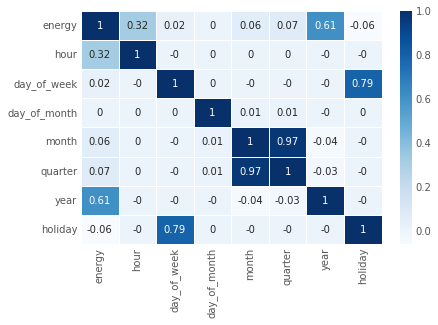

In [26]:
cor = round(df.corr(),2)
plt.style.use('ggplot')
sns.heatmap(cor, annot = True, linewidth = 0.5, cmap = 'Blues')

We can see that month and quarter columns are highly corelated to each other.

So we can drop quarter column.

In [27]:
df.drop(['quarter'], axis = 1, inplace = True)

**Seperating Dataset:**

In [28]:
# splitting data into training (2008-2014) and validation (2015-2018) set
train = df[df.index < '2015-01-01']
valid = df[df.index >= '2015-01-01']

Now separating target variable from independend data.

In [29]:
x_train = train.drop(['energy'], axis = 1)
x_valid = valid.drop(['energy'], axis = 1)
y_train = train['energy']
y_valid = valid['energy']

print(f'Shape of x_train -: {x_train.shape}')
print(f'Shape of x_valid -: {x_valid.shape}')
print(f'Shape of y_train -: {y_train.shape}')
print(f'Shape of y_valid -: {y_valid.shape}')

Shape of x_train -: (58755, 6)
Shape of x_valid -: (34337, 6)
Shape of y_train -: (58755,)
Shape of y_valid -: (34337,)


In [30]:
x_train.head()

,hour,day_of_week,day_of_month,month,year,holiday
datetime,,,,,,
2008-03-01 00:00:00,0,5,1,3,2008,1
2008-03-01 01:00:00,1,5,1,3,2008,1
2008-03-01 02:00:00,2,5,1,3,2008,1
2008-03-01 03:00:00,3,5,1,3,2008,1
2008-03-01 04:00:00,4,5,1,3,2008,1


In [31]:
x_train.columns

Index(['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'holiday'], dtype='object')

**Transformation:**
Using standard scaler    

In [32]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), index = x_train.index, columns = x_train.columns)
x_valid = pd.DataFrame(scaler.transform(x_valid), index = x_valid.index, columns = x_valid.columns)

x_train

,hour,day_of_week,day_of_month,month,year,holiday
datetime,,,,,,
2008-03-01 00:00:00,-1.661525,0.999385,-1.673353,-1.072682,-1.559547,1.579831
2008-03-01 01:00:00,-1.517089,0.999385,-1.673353,-1.072682,-1.559547,1.579831
2008-03-01 02:00:00,-1.372652,0.999385,-1.673353,-1.072682,-1.559547,1.579831
2008-03-01 03:00:00,-1.228216,0.999385,-1.673353,-1.072682,-1.559547,1.579831
2008-03-01 04:00:00,-1.083779,0.999385,-1.673353,-1.072682,-1.559547,1.579831
...,...,...,...,...,...,...
2014-12-31 19:00:00,1.082769,-0.500293,1.733719,1.575791,1.487665,-0.632979
2014-12-31 20:00:00,1.227205,-0.500293,1.733719,1.575791,1.487665,-0.632979
2014-12-31 21:00:00,1.371642,-0.500293,1.733719,1.575791,1.487665,-0.632979


### Creating Model:

we will check on two models: XGBoost and Random Forest Regressor

In [33]:
model_xgb = xgb.XGBRegressor(booster = 'gbtree', n_estimators = 100, max_depth = 3, eval_metric = 'rmse')

In [34]:
model_rfr = RandomForestRegressor(n_estimators = 100, max_depth = 15)

In [35]:
models = {'XGB Regressor' : model_xgb, 'Random Forest Regressor' : model_rfr}

Now we will check **accuracy for each model on training and testing dataset.**

In [36]:
def model_score(model, x_train, y_train, x_valid, y_valid):
    model.fit(x_train, y_train)
    y_preds= model.predict(x_valid)
    mse = mean_squared_error(y_valid, y_preds)
    return model.score(x_train, y_train), model.score(x_valid, y_valid), mse, np.sqrt(mse)

In [37]:
acc_train = []
acc_valid = []
mse = []
rmse = []

for key,value in models.items():
    acc_tr, acc_vd, mse_scr, rmse_scr = model_score(value, x_train, y_train, x_valid, y_valid)
    acc_train.append(acc_tr)
    acc_valid.append(acc_vd)
    mse.append(mse_scr)
    rmse.append(rmse_scr)
    
acc_data = pd.DataFrame({'Model' : models.keys(), 'Training Score' : acc_train, 'Validation Score' : acc_valid, 
                        'MSE' : mse, 'RMSE' : rmse})
acc_data

,Model,Training Score,Validation Score,MSE,RMSE
0,XGB Regressor,0.857602,0.372481,67514.216060,259.834979
1,Random Forest Regressor,0.970663,0.252685,80402.918122,283.554083


**Feature Importance:**

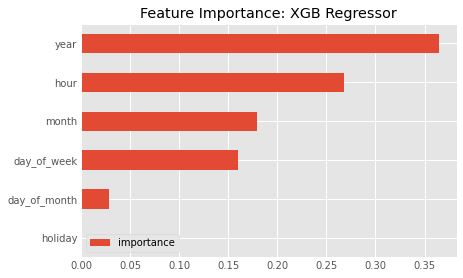

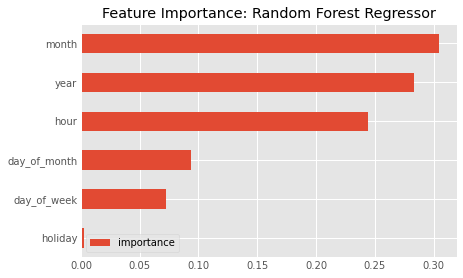

In [38]:
def feature_plot(model, model_name):
    f_imp = pd.DataFrame(data = model.feature_importances_, index = model.feature_names_in_, columns = ['importance'])
    f_imp.sort_values('importance').plot(kind = 'barh', title = f'Feature Importance: {model_name}')
    plt.show()
    
for key,value in models.items():
    feature_plot(value, key)

Model Selection:
From above results we are selecting xgb regressor as our final model.

**Hyperparameter tuning:**

We will use grid search cv for this.

In [39]:
model_s = xgb.XGBRegressor(booster = 'gbtree', eval_metric = 'rmse')

In [40]:
# defining parameters for grid search cv
parameters = {'n_estimators' : [20, 30, 50, 100, 500],
             'max_depth' : [2, 3, 5, 10, 15]}

In [41]:
grid_search = GridSearchCV(estimator = model_s, param_grid = parameters, cv = 4,
                           verbose = 1, scoring = 'neg_root_mean_squared_error')

In [42]:
grid_search.fit(x_train, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'max_depth': [2, 3, 5, 10, 15],
                         'n_estimators': [20, 30, 50, 100, 500]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [43]:
grid_search.best_score_

-190.63225404685693

In [45]:
grid_search.score(x_train,y_train)

-108.9456226046447

In [46]:
grid_search.best_params_

{'max_depth': 5, 'n_estimators': 30}

**Final Model:**
XGB Regressor with Best estimator will be our final model.

In [47]:
final_model = xgb.XGBRegressor(booster = 'gbtree', max_depth=5, n_estimators=30, eval_metric = 'rmse', random_state=0)

In [48]:
final_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=30, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [49]:
y_preds_final= final_model.predict(x_valid)

In [50]:
np.sqrt(mean_squared_error(y_valid, y_preds_final))

260.15422542151026

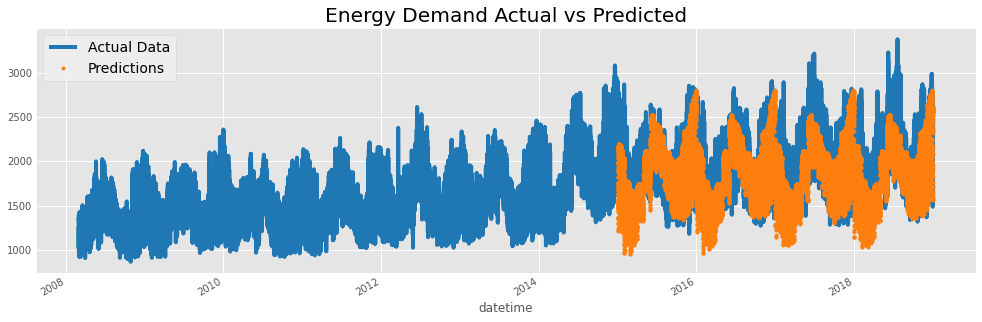

In [51]:
df_valid = valid.copy()
df_valid['prediction'] = y_preds_final
df['energy'].plot(figsize = (15,5), color = color_pal[0])
df_valid['prediction'].plot(style = '.', color = color_pal[1], figsize = (15,5))
plt.style.use('fivethirtyeight')
plt.legend(['Actual Data', 'Predictions'])
plt.title("Energy Demand Actual vs Predicted")
plt.show()

> **However this model is giving less accuracy for prediction. Basically its overfitted. We will try to solve this issue by applying more machine learning techniques.**



# Next Steps:


- More robust cross validation.
- We can select different ml model and tune their hyperparameter.
- Add more features and select important one.

Now we will define custom function that we generate future energy consmption as we give input as Data frame (include row-id, datetime columns) to it.

In [55]:
def custom_predict(df_test):
    df_pred = df_test.copy()
    df_test.drop(["row_id"], axis = 1, inplace = True)
    df_test = df_test.set_index("datetime")
    df_test.index = pd.to_datetime(df_test.index)
    df_test = create_features(df_test)
    df_test = holiday_mark(df_test)
    df_test.drop(['quarter'], axis = 1, inplace = True)
    df_test = pd.DataFrame(scaler.transform(df_test),index = df_test.index, columns = df_test.columns)
    
    y_predict = final_model.predict(df_test)
    df_pred['energy'] = y_predict
    return df_pred

In [56]:
# importing testing data
df_test = pd.read_csv('test_WudNWDM.csv')

In [57]:
df_submit = custom_predict(df_test)
df_submit

,row_id,datetime,energy
0,94993,2019-01-01 00:00:00,1563.198486
1,94994,2019-01-01 01:00:00,1473.931274
2,94995,2019-01-01 02:00:00,1408.741455
3,94996,2019-01-01 03:00:00,1356.422607
4,94997,2019-01-01 04:00:00,1342.450684
...,...,...,...
26299,121292,2021-12-31 19:00:00,2776.353271
26300,121293,2021-12-31 20:00:00,2734.116455
26301,121294,2021-12-31 21:00:00,2691.237549
26302,121295,2021-12-31 22:00:00,2632.737549


In [58]:
# creating csv file with output 
df_submit.to_csv("sample_submission_jn0a7vR.csv", index = False)